# 代码实现

接下来将编程实现椒盐噪声。

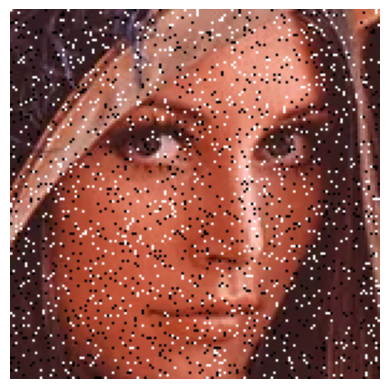

In [2]:
# 第2章编写了utils函数包文件，本书编写的函数都会封装到utils函数包中。
from utils import *

# 添加椒盐噪声
def add_Salt(img, pro):
    # img为输入图像
    # pro为椒盐噪声的比例
    
    # 添加黑色像素点
    noise = np.random.uniform(0, 255, img[:, :, 0].shape)
    # mask为添加噪声的掩模
    mask = noise < pro * 255
    # 扩展mask的维度
    mask = np.expand_dims(mask, axis=2)
    mask = np.repeat(mask, 3, axis=2)    
    img = img * (1 - mask)
     
    # 添加白色像素点
    mask = noise > 255 - pro * 255    
    mask = np.expand_dims(mask, axis=2)
    mask = np.repeat(mask, 3, axis=2)
    noise_img = 255 * mask + img * (1 - mask)
    
    return noise_img


img = cv2.imread('lenaface.jpg')
# 添加椒盐噪声的图像：
img_salt = add_Salt(img, 0.05)
plt.imshow(img_salt[:,:,::-1])
plt.axis('off')
plt.show()

下面，我们将编程实现高斯噪声，首先按照二维高斯分布随机生成噪声样本，并将其添加到图像中。

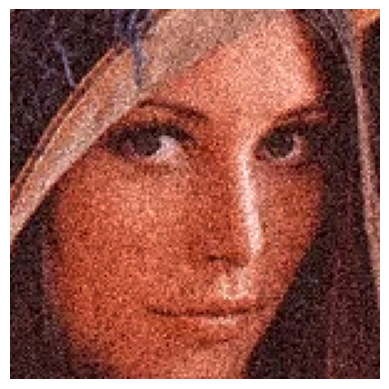

In [3]:
def add_Gaussian(img, sigma=20, mean=0):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    # 生成高斯噪声
    noise = np.random.normal(mean, sigma, lab[:, :, 0].shape)
    lab = lab.astype(float)
    # 添加高斯噪声
    lab[:, :, 0] = lab[:, :, 0] + noise
    lab[:, :, 0] = np.clip(lab[:, :, 0], 0, 255)
    lab = lab.astype(np.uint8)
    noise_img = cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)
    return noise_img

# 添加高斯噪声的图像
img_gaussian = add_Gaussian(img)
plt.imshow(img_gaussian[:,:,::-1])
plt.axis('off')
plt.show()



接下来，我们对3.2.2节生成的有高斯噪声的人脸图像进行均值滤波，并观察它的效果。

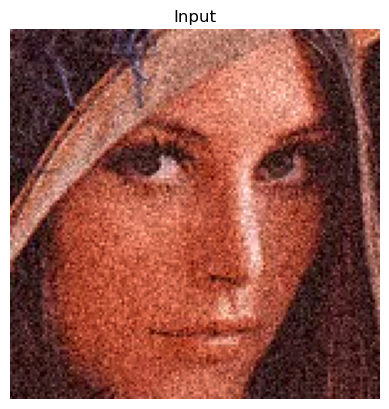

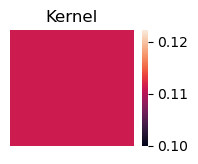

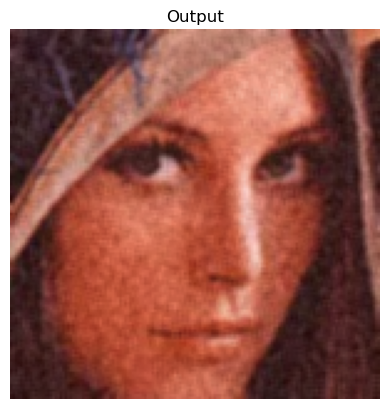

In [3]:
# 均值滤波器 size=3
size = 3
k3 = 1/size/size * np.ones((size, size))

# 展示输入图像与滤波核
conv_gaussian = conv_2d(img_gaussian, k3)
conv_gaussian.plot()

# 展示卷积结果
conv_gaussian.plot_conv()

可以看出图像变的平滑了，但噪声依旧存在。我们增加均值滤波器的大小，并再次测试。

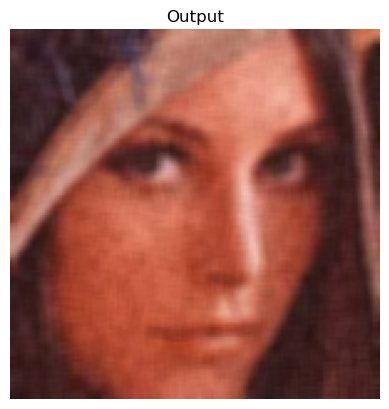

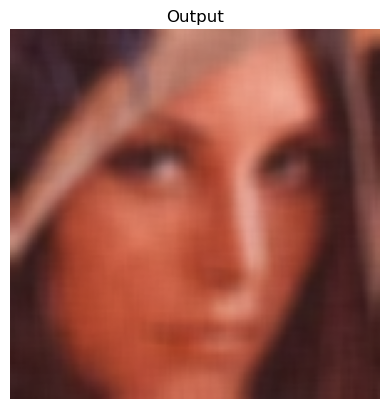

In [4]:
# 均值滤波器 size=5
size = 5
k5 = 1/size/size *np.ones((size,size))

conv = conv_2d(img_gaussian, k5)

# 展示卷积结果
conv.plot_conv()


# 均值滤波器 size=9
size = 9
k9 = 1/size/size * np.ones((size, size))

conv = conv_2d(img_gaussian, k9)
# 展示卷积结果
conv.plot_conv()

这时，可以很明显的看出，当均值滤波器的大小为$5\times5$时，噪声基本消失不见；而当滤波器大小为$9\times9$时，不仅噪声消除了，图像也变得模糊了。因此在实际滤波过程中，需要为滤波器选择合适的大小，尽可能在保留图像特征的情况下消除噪声。



接下来，将编程实现高斯滤波器，并测试其效果。


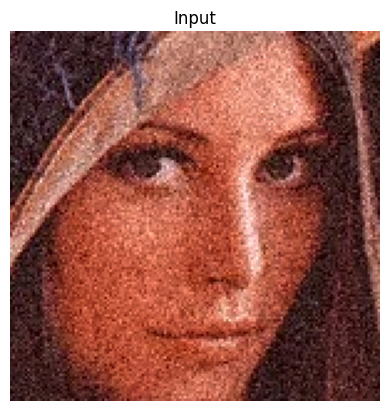

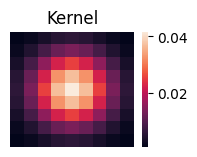

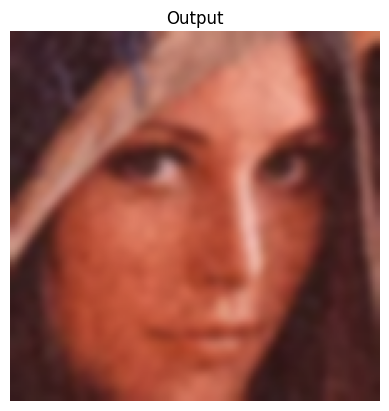

In [5]:
# 定义高斯核

def gauss(kernel_size, sigma):
    
    kernel = np.zeros((kernel_size, kernel_size))
    # 定义中心点坐标
    center = kernel_size // 2
    s = sigma ** 2
    sum_val =  0
    # 计算每个位置的高斯核权重
    for i in range(kernel_size):
        for j in range(kernel_size):
            x, y = i-center, j-center
            
            kernel[i, j] = np.exp(-(x**2 + y**2)/ 2 * s)
            sum_val += kernel[i, j]
    
    kernel = kernel/sum_val
    
    return kernel


k_gaussian = gauss(9, 0.5)
# 展示输入图像与滤波核
conv = conv_2d(img_gaussian, k_gaussian)
conv.plot()

# 展示卷积结果
conv.plot_conv()

我们通过对比输入图像和输出图像，可以很明显的看出高斯噪声被有效地抑制，看来高斯噪声还得是高斯滤波器才能有效地去除。我们改变高斯核的大小，并再次测试。

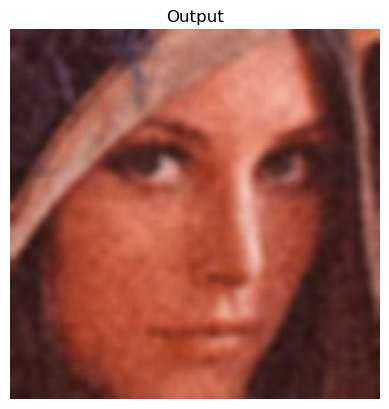

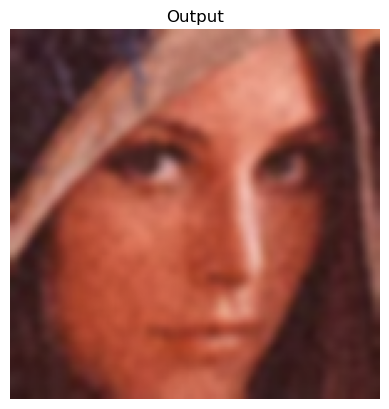

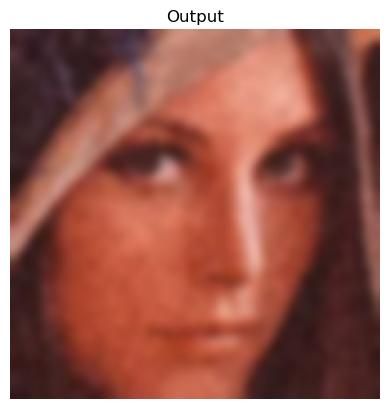

In [6]:
# 高斯核大小为5
conv1 = conv_2d(img_gaussian, gauss(5, 0.5))
conv1.plot_conv()

# 高斯核大小为7
conv2 = conv_2d(img_gaussian, gauss(7, 0.5))
conv2.plot_conv()

# 高斯核大小为11
conv3 = conv_2d(img_gaussian, gauss(11, 0.5))
conv3.plot_conv()

可以看出，高斯滤波器在有效处理高斯噪声的同时，也避免了使用均值滤波时出现的“块状效应”。在之后的代码中，我们可以使用cv2.GaussianBlur()对图像进行高斯滤波。

我们把双边滤波器的实现留给大家作为作业，我们将调用库函数cv2.bilateralFilter()对图像进行双边滤波。

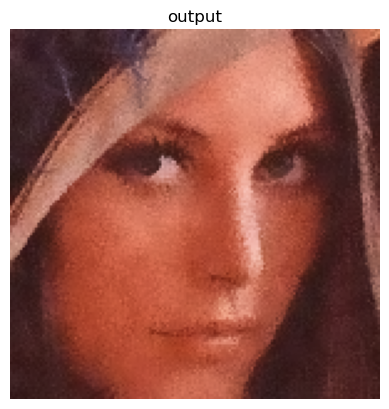

In [18]:
# 为了之后展示图像更加方便，我们将该功能封装成一个函数
def plot_image(img, name, camp='gray'):
    plt.imshow(img, cmap=camp)
    plt.title(name)
    plt.axis('off')
    plt.show()

# 展示双边滤波器过滤高斯噪声的效果
plot_image(cv2.bilateralFilter(np.uint8(img_gaussian),10,110,5)[:, :, ::-1], 'output')


如图所示，双边滤波器在去噪的同时也很好的保持图像内容的清晰度，例如眼睛部位灰色的色块明显减少了。


祛痘也是美颜修图时的一个常用操作。人脸上的“痘”其实就是一种椒盐噪声。我们先试试高斯滤波器对椒盐噪声的效果，观察高斯滤波器能否有效“祛痘”。

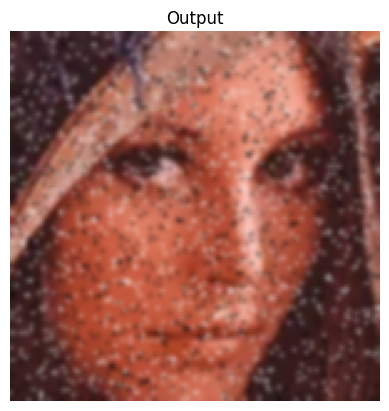

In [8]:
# 使用高斯滤波器过滤椒盐噪声
conv_salt = conv_2d(np.uint8(img_salt), gauss(5, 1))
conv_salt.plot_conv()

看来高斯滤波器无法有效处理椒盐噪声，因为高斯滤波器本质上是将部分像素点加权求和，并不能够抵抗椒盐噪声的影响。那么接下来，我们将介绍一种有效处理椒盐噪声的滤波器：中值滤波器。


我们把中值滤波器的实现留给大家作为作业，我们将调用库函数cv2.medianBlur()对图像进行中值滤波，观察其对椒盐噪声的抑制效果。

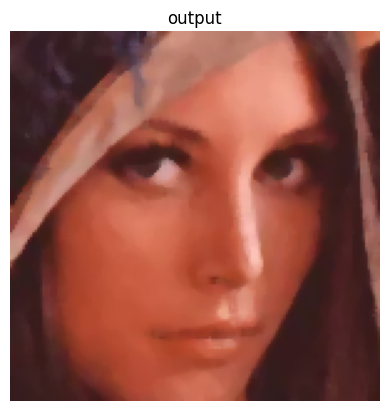

In [9]:
conv_salt = conv_2d(img_salt, k3)
plot_image(cv2.medianBlur(np.uint8(img_salt),5)[:, :, ::-1], 'output')

图中的人脸是不是看上去非常清晰？经过中值滤波器滤波之后，图像中连一点椒盐噪声的影子都看不见了。看来中值滤波器对椒盐噪声确实非常有效。

既然可以通过滤波的方式让图像变得平滑，那么也可以让图像变得清晰，这一过程被称作图像锐化。如前所述，图像平滑是滤掉图像中高频信息，保留低频信息，那么图像锐化是不是反其道而行之，去掉低频信息，保留高频信息就可以实现了？试想一下，当一张图像经过高斯滤波之后，它的高频信息被滤波器所去除，只保留了低频信息。如果我们用原图像减去滤波后的图像，是不是就可以得到图像中更多的高频信息？那我们先这样试验一下：

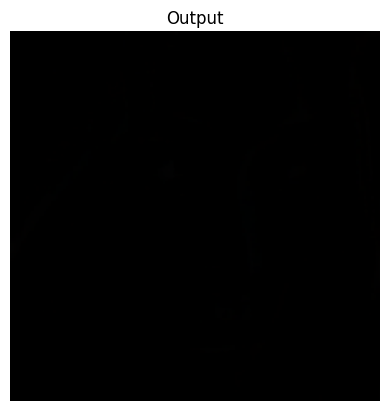

In [12]:
# 由于卷积具有分配律，我们可以直接计算叠加后的卷积核
size = 3
k0 = np.zeros((size, size))
k0[int((size-1)/2)][int((size-1)/2)] = 1

kg = gauss(size, 1)
k_shapen = 1 * (k0 - kg)

# 得到高斯滤波的图像
img_gau = cv2.GaussianBlur(img, (9,9), 5)
shapen = conv_2d(img_gau, k_shapen)
# 展示锐化效果
shapen.plot_conv()

好像和预计的结果不相符，大家知道是哪里出了问题吗？图像中的高频信息是很少的，低频信息才是主体，所以仅保留高频信息得到的就是这样一张“黑图”。修正我们的想法：图像锐化是增强高频信息，而不是完全去除低频信息。

所以再进行以下尝试：再把原图加回到上面这张“黑图”，那就是在保留原来图像低频信息的同时，将高频信息增加了一倍。那如果把上面这张“黑图”多次叠加到原图上，图像是不是会越来越清晰？

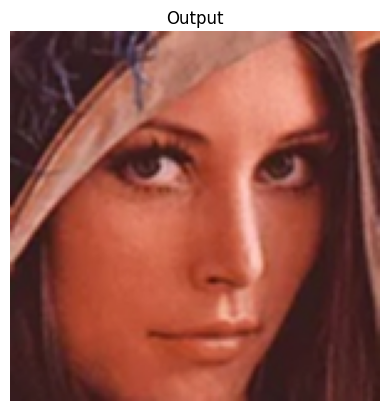

In [7]:
# 构建滤波核
k_shapen = k0 + 1 * (k0 - kg)
img_gau = cv2.GaussianBlur(img, (3,3), 1)
shapen = conv_2d(img_gau, k_shapen)
shapen.plot_conv()

图像明显变得清晰了。将高频信息与原图像多次叠加，并测试其效果。

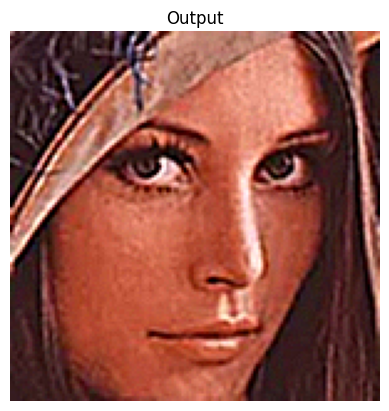

In [10]:
k_shapen = k0 + 10 * (k0 - kg)
img_gau = cv2.GaussianBlur(img, (3,3), 1)
shapen = conv_2d(img_gau, k_shapen)
shapen.plot_conv()

由此可见将原图减去高斯滤波后的图像，即图像的高频信息，反复叠加在原图上，可以不断增强锐化的效果。